# Explore the dependency between time and occupancy at the car parkings 

In [407]:
import numpy as np
import pandas as pd
from datetime import datetime
import operator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

https://core.ac.uk/download/pdf/132743553.pdf <br>
https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c <br>
https://developers.google.com/machine-learning/clustering <br>

https://towardsdatascience.com/machine-learning-birch-clustering-algorithm-clearly-explained-fb9838cbeed9 BIRCH <br>
https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5 DBSCAN <br>

https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95 Gaussian Mixture model<br>

## Data
Data collected from car parks in Birmingham. Occupancy rates (8:00 to 16:30) from 2016/10/04 to 2016/12/19. This problem deals with dependency between time and occupancy the car park.

### Load the data and investigate features
Check for missing values. Fix or drop if it's in SystemCodeNumber.

In [357]:
df = pd.read_csv('dataset.csv')
df.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577.0,61.0,2016-10-04 07:59:42
1,BHMBCCMKT01,577.0,64.0,2016-10-04 08:25:42
2,BHMBCCMKT01,NaN,80.0,2016-10-04 08:59:42
3,BHMBCCMKT01,NaN,NaN,2016-10-04 09:32:46
4,BHMBCCMKT01,577.0,150.0,2016-10-04 09:59:48


Each parking building has a constant capacity through the time of monitoring. So we can change all possible NaN values there with known capacity for a given SystemCodeNumber. Also, replace occupancy number with percentage.

In [358]:
df.dropna(subset=["Occupancy"], inplace=True)

capacity_values = {row['SystemCodeNumber']:row['Capacity'] for (index, row) in df.iterrows() if row['Capacity']}
for index, row in df.iterrows():
    df.loc[index, 'Capacity'] = capacity_values[row['SystemCodeNumber']]
    df.loc[index, 'Occupancy'] = 100 / (capacity_values[row['SystemCodeNumber']] / row['Occupancy']) if row['Occupancy'] > 0 else 0

df.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577.0,10.571924,2016-10-04 07:59:42
1,BHMBCCMKT01,577.0,11.091854,2016-10-04 08:25:42
2,BHMBCCMKT01,577.0,13.864818,2016-10-04 08:59:42
4,BHMBCCMKT01,577.0,25.996534,2016-10-04 09:59:48
5,BHMBCCMKT01,577.0,30.675910,2016-10-04 10:26:49


Rewrite 'SystemCodeNumber' column as binary columns of different parking types to express the location dependance.

In [359]:
df = pd.get_dummies(df, columns=['SystemCodeNumber'])

Split date into 'month', 'day' columns (ignore year - it's const in this data set); split time into h, m, s columns. 

In [360]:
df['LastUpdated'] = pd.to_datetime(df['LastUpdated'], infer_datetime_format=True)

df['LastUpdated_Month'] = [int(dt.month) for dt in df['LastUpdated']]
df['LastUpdated_Day'] = [int(dt.day) for dt in df['LastUpdated']]

df['LastUpdated_Hour'] = [int(dt.hour) for dt in df['LastUpdated']]
df['LastUpdated_Minute'] = [int(dt.minute) for dt in df['LastUpdated']]

df.drop(["LastUpdated"], axis=1, inplace=True)

df.head()

,Capacity,Occupancy,SystemCodeNumber_BHMBCCMKT01,SystemCodeNumber_BHMBCCPST01,SystemCodeNumber_BHMBCCSNH01,SystemCodeNumber_BHMBCCTHL01,SystemCodeNumber_BHMBRCBRG01,SystemCodeNumber_BHMBRCBRG02,SystemCodeNumber_BHMBRCBRG03,SystemCodeNumber_BHMBRTARC01,...,SystemCodeNumber_Others-CCCPS133,SystemCodeNumber_Others-CCCPS135a,SystemCodeNumber_Others-CCCPS202,SystemCodeNumber_Others-CCCPS8,SystemCodeNumber_Others-CCCPS98,SystemCodeNumber_Shopping,LastUpdated_Month,LastUpdated_Day,LastUpdated_Hour,LastUpdated_Minute
0,577.0,10.571924,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,4,7,59
1,577.0,11.091854,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,4,8,25
2,577.0,13.864818,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,4,8,59
4,577.0,25.996534,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,4,9,59
5,577.0,30.675910,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,4,10,26


Split data set into training (80%) and tesing (20%) subsets.

#### Split the dataset into two subsets: train and test (80:20 %).

In [361]:
df_train, df_test = train_test_split(df, test_size=0.2)

## Models

### Train two clustering algorithms and check their accuracy

### 1. K-Means

Use the Elbow method to estimate the best number of clusters for the K-nearest Neighbours algorithm.

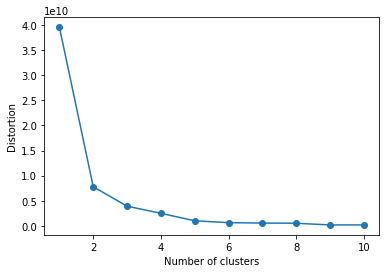

In [362]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_train)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [363]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(df_train)
y_km_test = km.fit_predict(df_test)

### 2. BIRCH 
A memory-efficient, online-learning algorithm provided as an alternative to MiniBatchKMeans. It constructs a tree data structure with the cluster centroids being read off the leaf. These can be either the final cluster centroids or can be provided as input to another clustering algorithm such as AgglomerativeClustering.

In [364]:
brc = Birch(n_clusters=3)
y_brc = brc.fit_predict(df_train)
y_brc_test = brc.fit_predict(df_test)

### Check the accuracy of tested models

In [365]:
print("KMeans \n on train set: {}, \t on test set: {}\n".format(
    silhouette_score(df_train, y_km, metric='euclidean', sample_size=None, random_state=None),
    silhouette_score(df_test, y_km_test, metric='euclidean', sample_size=None, random_state=None)))

print("BIRCH \n on train set: {}, \t on test set: {}".format(
    silhouette_score(df_train, y_brc, metric='euclidean', sample_size=None, random_state=None),
    silhouette_score(df_test, y_brc_test, metric='euclidean', sample_size=None, random_state=None)))

KMeans 
 on train set: 0.7440244913972092, 	 on test set: 0.7463373133305784

BIRCH 
 on train set: 0.6591553508987315, 	 on test set: 0.660319091822819


In [367]:
print("KMeans \n on train set: {}, \t on test set: {}\n".format(
    davies_bouldin_score(df_train, y_km),
    davies_bouldin_score(df_test, y_km_test)))

print("BIRCH \n on train set: {}, \t on test set: {}\n".format(
    davies_bouldin_score(df_train, y_brc),
    davies_bouldin_score(df_test, y_brc_test)))

# warnings https://github.com/scikit-learn/scikit-learn/issues/12611

KMeans 
 on train set: 0.471545746052298, 	 on test set: 0.466717005840636

BIRCH 
 on train set: 0.5357892378014012, 	 on test set: 0.5268183365018563



/home/anastasiia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/anastasiia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/anastasiia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/anastasiia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


---
---
---

# Find relation between the content type in Facebook and the types of reaction from a user. 

## Data

Load data from `Live.csv` and investigate the features. Fix or drop entries with missing values.

In [380]:
fb_df = pd.read_csv('Live.csv')
fb_df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


Drop a column only if it's completely empty. Drop a status_id column completely.

In [381]:
fb_df.dropna(axis='columns', how='all', inplace=True)
X = fb_df.drop(axis='columns', labels='status_id')
X = pd.get_dummies(X, columns=['status_type'])

X['status_published'] = pd.to_datetime(X['status_published'], infer_datetime_format=True)
X['status_published_month'] = [int(dt.month) for dt in X['status_published']]
X['status_published_day'] = [int(dt.day) for dt in X['status_published']]
X['status_published_hour'] = [int(dt.hour) for dt in X['status_published']]
X.drop(["status_published"], axis=1, inplace=True)

X.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,status_published_month,status_published_day,status_published_hour
0,529,512,262,432,92,3,1,1,0,0,0,0,1,4,22,6
1,150,0,0,150,0,0,0,0,0,0,1,0,0,4,21,22
2,227,236,57,204,21,1,1,0,0,0,0,0,1,4,21,6
3,111,0,0,111,0,0,0,0,0,0,1,0,0,4,21,2
4,213,0,0,204,9,0,0,0,0,0,1,0,0,4,18,3


Split the dataset into two subsets: train and test (80:20 %).

In [382]:
x_train, x_test = train_test_split(X, test_size=0.2)

## Models
(Unsupervised learning)

## Training K-means

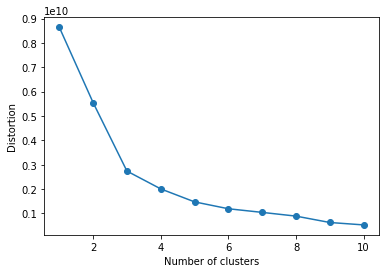

In [383]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [394]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(x_train)
print(y_km.shape, x_train.shape)

# y_km_test = km.fit_predict(x_test)

(5640,) (5640, 16)


0 : 4968

2 : 328

3 : 291

1 : 53



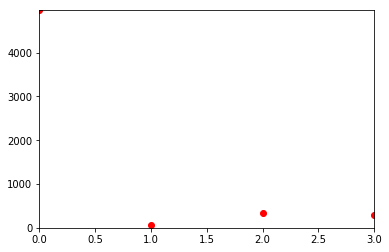

In [385]:
y_km_stats = {}
for ctr_id in y_km:
    if ctr_id in y_km_stats:
        y_km_stats[ctr_id] += 1
    else:
        y_km_stats[ctr_id] = 1

for key in y_km_stats:
    print("{} : {}\n".format(key, y_km_stats[key]))
        
plt.axis([0, 3, 0, max(y_km_stats.items(), key=operator.itemgetter(1))[1]])
plt.plot([k for k in y_km_stats], [y_km_stats[k] for k in y_km_stats], 'ro')

We can see on the "print and plot" that one cluster is A LOT bigger than all the others summed together. Which is probably not good, but typical for the K-Means algorithm.  

## Agglomerative clustering algorithm based on hierarchy
Initially considers each entry as a separate cluster; Merges the closest two of them at each step, until all data is combined into one big cluster.


In [386]:
cst = AgglomerativeClustering(n_clusters=4)
y_cst = cst.fit_predict(x_train)
# y_cst_test = cst.fit_predict(x_test)

0 : 5097

2 : 417

1 : 123

3 : 3



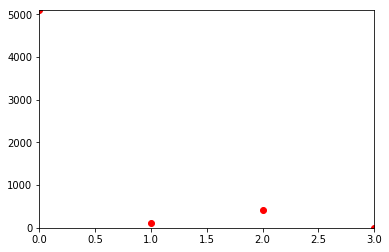

In [387]:
y_km_stats = {}
for ctr_id in y_cst:
    if ctr_id in y_km_stats:
        y_km_stats[ctr_id] += 1
    else:
        y_km_stats[ctr_id] = 1

for key in y_km_stats:
    print("{} : {}\n".format(key, y_km_stats[key]))
        
plt.axis([0, 3, 0, max(y_km_stats.items(), key=operator.itemgetter(1))[1]])
plt.plot([k for k in y_km_stats], [y_km_stats[k] for k in y_km_stats], 'ro')

In [401]:
dbc = DBSCAN(eps=8, min_samples=10)
y_dbc = dbc.fit_predict(x_train)
y_dbc_test = dbc.fit_predict(x_test)

### Check the accuracy of tested models

In [402]:
print("KMeans \n on train set: {}, \t on test set: {}\n".format(
    silhouette_score(x_train, y_km, metric='euclidean', sample_size=None, random_state=None),
    silhouette_score(x_test, y_km_test, metric='euclidean', sample_size=None, random_state=None)))

print("Aglomerative Hierarchial \n on train set: {}, \t on test set: {}".format(
    silhouette_score(x_train, y_cst),
    silhouette_score(x_test, y_cst_test)))

print("DBSCAN \n on train set: {}, \t on test set: {}".format(
    silhouette_score(x_train, y_dbc),
    silhouette_score(x_test, y_dbc_test)))

KMeans 
 on train set: 0.8053919259151147, 	 on test set: 0.7762666119097694

Aglomerative Hierarchial 
 on train set: 0.7713659008747303, 	 on test set: 0.7736210094796422
DBSCAN 
 on train set: 0.22439910613787456, 	 on test set: -0.3431989132916327


---
---
---

# Anomaly detection for datacenter

Building a model, which finds anomalies in the behavior of virtual machines in the datacenter.

In [408]:
X = pd.read_csv('system-load.csv')
vm_df.head()

,cpu_load,ram_usage
0,1.29,290
1,2.66,332
2,0.88,372
3,2.57,362
4,2.44,480


### Training Gaussian mixture model

In [409]:
gm = GaussianMixture()
y = gm.fit_predict(X)

### Setting up model parameters

### Plotting the results